# Differentiating Regular and Pneumonia X-rays with ML
### By Haoyuan Pang and Bradley Russavage

In [20]:
# Import required libraries
import os
import cv2 # opencv
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

## Define Functions

In [2]:
main_path = os.getcwd() + '/data/covid_xray/'
train_path = main_path + 'train/'
test_path = main_path + 'test/'

max_dim = 200 # pixels
normal = []
pneumonia = []

def precision_recall(conf_matrix):
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp 
    fn = np.sum(conf_matrix, axis=1) - tp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall


def get_metrics(y_test, predicted):
    conf_matrix = confusion_matrix(y_test, predicted)
    plt.imshow(conf_matrix)
    print(pd.DataFrame(conf_matrix, columns=[0,1], index=[0,1]))
    print(precision_recall(conf_matrix))
    
    
# Requires images to be downloaded
def convert_images(subpath):
    global normal, pneumonia
    for i in ['NORMAL/', 'PNEUMONIA/']:
        path = subpath + i
        for xray in os.listdir(path):
            # print(xray) # image name

            # Convert image to np array using opencv
            try:
                img = cv2.imread(path + xray)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
                img_resize = cv2.resize(img, (max_dim, max_dim), cv2.INTER_AREA) # shrink img to 200 by 200
                
                
                if i == "NORMAL/":
                    normal.append(img_resize)
                    #normal = np.append(normal, img_resize, axis=0)
                else:
                    pneumonia.append(img_resize)
                    #pneumonia = np.append(pneumonia, img_resize, axis=0)
                    
            except Exception as e:
                print(e)

        print("Finished " + i)

## Data preprocessing

In [ ]:
# Only use these functions if you have the data manually downloaded

#convert_images(train_path)
#convert_images(test_path)

# Write to a file for ease of data access
# normal = np.asarray(normal)
# pneumonia = np.asarray(pneumonia)
# np.save(main_path + "normal_arr.npy", normal)
# np.save(main_path + "pneu_arr.npy", pneumonia)

# Load data from data.npy
#normal = np.load(main_path + "normal_arr.npy", allow_pickle=True)
#pneumonia = np.load(main_path + "pneu_arr.npy", allow_pickle=True)

#print(normal.shape)
#print(pneumonia.shape)

In [3]:
# Load data from silk server
URL_NORM = "https://brussava.w3.uvm.edu/cs254/covid_xray/normal_arr.npy"
resp = requests.get(URL_NORM)
resp.raise_for_status()
normal = np.load(io.BytesIO(resp.content), allow_pickle=True)

URL_PNEU = "https://brussava.w3.uvm.edu/cs254/covid_xray/pneu_arr.npy"
resp = requests.get(URL_PNEU)
resp.raise_for_status()
pneumonia = np.load(io.BytesIO(resp.content), allow_pickle=True)


print(f"Normal size: {normal.shape}")
print(f"Pneumonia size: {pneumonia.shape}")

Normal size: (1575, 200, 200)
Pneumonia size: (4265, 200, 200)


In [4]:
# Visualize an xray image
print(normal[1])

# This shows as a popup window
#cv2.imshow('Test', normal[1])
#cv2.waitKey(0) # Do not delete this line or the notebook kernel will crash

[[14 23 27 ... 29 23 19]
 [19 21 27 ... 31 25 18]
 [14 24 29 ... 27 23 17]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [5]:
# Convert from 3D to 2D
print("Before flattening")
print(normal.shape)
print(pneumonia.shape)

examples_n, dim_x_n, dim_y_n = normal.shape
normal = normal.reshape((examples_n, dim_x_n * dim_y_n))

examples_p, dim_x_p, dim_y_p = pneumonia.shape
pneumonia = pneumonia.reshape((examples_p, dim_x_p * dim_y_p))

print("\nAfter flattening")
print(normal.shape)
print(pneumonia.shape)

# Create X and Y
X = np.append(normal, pneumonia, axis=0)
y = np.array([0 for _ in range(normal.shape[0])])
y = np.append(y, [1 for _ in range(pneumonia.shape[0])], axis=0)


# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print("Training x:", x_train.shape, "y:", y_train.shape)
print("Testing x:", x_test.shape, "y:", y_test.shape)

print("Before normalization:")
print(x_train[10])

# Normalize RGB values from 0-255 to 0-1 (div by 255)
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

print("\nAfter normalization:")
print(x_train[10])

Before flattening
(1575, 200, 200)
(4265, 200, 200)

After flattening
(1575, 40000)
(4265, 40000)
Training x: (4380, 40000) y: (4380,)
Testing x: (1460, 40000) y: (1460,)
Before normalization:
[  0   0   0 ...   0   0 101]

After normalization:
[0.         0.         0.         ... 0.         0.         0.39607843]


## Models

### Logistic Regression

In [23]:
# Probably switch to RF or a cnn


#log_reg = LogisticRegression(solver="saga", max_iter=300, random_state=0)
# log_reg = LogisticRegression(solver="saga", random_state=0)
# log_reg = log_reg.fit(x_train_ss, y_train_ss)
# log_reg_pred = log_reg.predict(x_test_ss)

### Logistic Regression Results

In [25]:
#get_metrics(y_test, log_reg_pred)

### SVM

In [24]:
svc = SVC(kernel="poly")
svc_predicted = svc.fit(x_train, y_train).predict(x_test)

### SVM Metrics

     0     1
0  341    55
1   29  1035
(array([0.92162162, 0.94954128]), array([0.86111111, 0.97274436]))


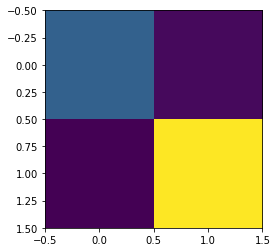

In [26]:
get_metrics(y_test, svc_predicted)